# Segmentation and separation of the image

Load the segmentation that was generated by ML segmentation

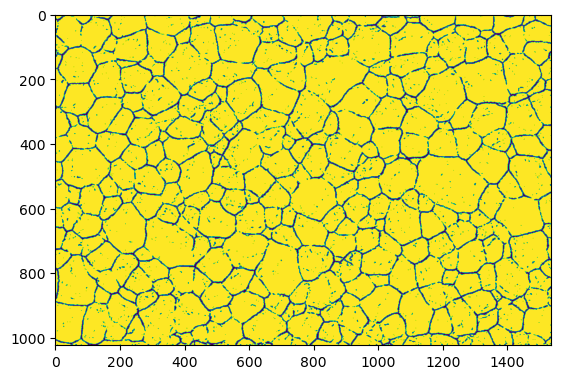

In [38]:
from skimage.io import imread
from pathlib import Path
from matplotlib import pyplot as plt
import napari

tnia_images_path = Path("D:/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2024_03_05_sem_grain_size"

image = imread(str(parent_path / ("SEM.tif")))
segmented = imread(str(parent_path / ("segmented.tif")))

plt.imshow(segmented)

## Get rid of noise

In some images we could use binary operations like 'opening' and 'closing' to get rid of small objects.  The problem in this case is closing would get rid of the small noise holes, but also some of the outline.

Instead we try the following strategy.

1.  Create a binary image where the outlines are 1 and the grains 0.
2.  Label (count) the image.  The outlines will be connected and form a few large objects, but the small holes will be isolated.
3.  Filter out the isolated holes by area.

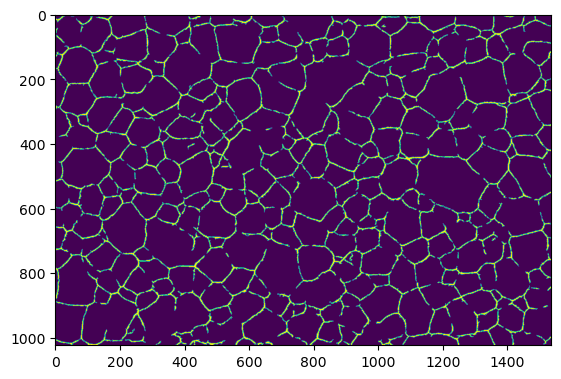

In [39]:
import numpy as np
from skimage.measure import label
from skimage.measure import regionprops

outlines = np.zeros_like(segmented)
outlines[segmented==1]=1

labeled = label(outlines)

min_area = 50

object_list=regionprops(labeled)
labeled_filtered=np.zeros_like(labeled)

for obj in object_list:
    
    if obj.area > min_area:
        labeled_filtered[labeled==obj.label]=1

plt.imshow(labeled_filtered)

## Invert the image

We do this so the grains are positive again

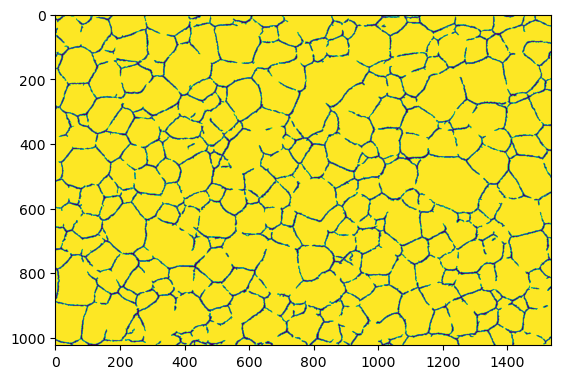

In [40]:
labeled_filtered = 1 - labeled_filtered
plt.imshow(labeled_filtered)

## Create separate function

In [43]:
from scipy import ndimage as ndi
from skimage.morphology import  disk
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import erosion

def separate_touching(segmented, min_distance, num_erosions):
    """ separates touching objects using a watershed process using strategy described here https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html

    Args:
        segmented (2d np array): pre-segmented image
        min_distance (int):  minimum distance between separated
        num_erosions (int): number of erosions to perform at end of process, in order to increase separation between split objects. 

    Returns:
        2d np array:  separated binary image, labels, distance map
    """

    #closed = closing(segmented, disk(1))
    #eroded = erosion(closed, disk(2))
    distance = ndi.distance_transform_edt(segmented)
    coords = peak_local_max(distance, min_distance=min_distance, exclude_border=False)
    #print(coords.shape)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=segmented, watershed_line=True)
    separated = labels
    separated[labels>0]=1

    for i in range(num_erosions):
        separated = erosion(separated, disk(1))

    return separated, labels, distance



## Apply the separate function

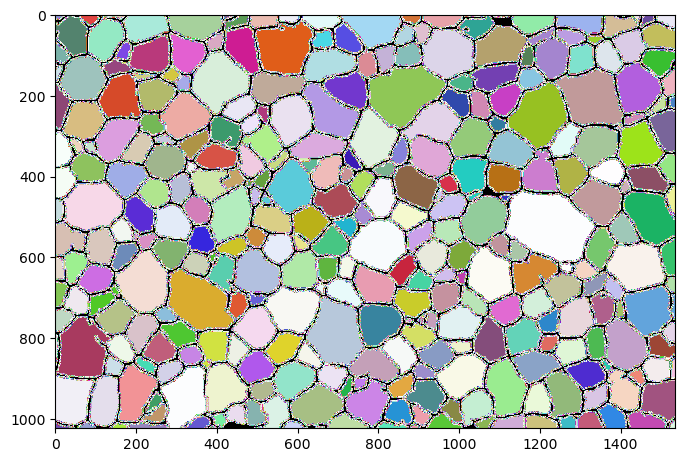

In [51]:
# import random label cmap
from cv2 import imshow
from tnia.plotting.plt_helper import random_label_cmap, imshow2d
from matplotlib.colors import ListedColormap

separated, separated_labeled, _ = separate_touching(labeled_filtered, min_distance=20, num_erosions=2)
labels = label(separated)

fig = imshow2d(labels, colormap=random_label_cmap())

In [45]:
import napari


viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(labels)

<Labels layer 'labels' at 0x199552b93d0>